# Monitoring and Predicting Elasticity in Kubernetes

In [73]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime
import json
import scipy.signal as ss
import math

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

# Introduction

## Goal of this project

This project has two main goals:

### 1. Monitoring Kubernetes:
Investigating ways to monitor Kubernetes in order to get information about the configuration of the deployed Software system at runtime. In particular, we are interested how many pods of each service are running and to which compute nodes they are scheduled. 

### 2. Predicting reconfigurations:
Learning behavioral patterns of Kubernetes in order to be able to predict reconfigurations, such as elastic rescaling, i.e. addition or removal of pods of specific services.

## Background
The main motivation for this work, is to provide information about the current configuration of the deployed system to an online model checker that verifies the correctness of every new system configuration. 
In a second step, the prediciton could be used to precompute model checking results at times where the model checker would otherwise be idle.

## Setup
All parts of the project were tested on a local Kubernetes cluster run on [Minikube](https://kubernetes.io/docs/tasks/tools/install-minikube/). As currently the support for running multi node clusters locally is very limited, all experiments were run in a setup with only one compute node. The virtual machine running the compute node had access to the following resources:

* 6 cores
* 6 GB RAM
* 32 GB disk storage

Testing similar solutions on clusters with multiple nodes and more compute power would be an interesting future extension.

### Example application
As example application that is deployed on Kubernetes I used a Google demo application which implements an online shop where users can browse items, add them to the cart, and purchase them. Code, build and deployment instructions can be found [here](https://github.com/GoogleCloudPlatform/microservices-demo).
The application consists of 10 different microservices. The following two microserveices are of importance for the experiments run in this project:

##### Frontend
Exposes an HTTP server to serve the website. 

##### Loadgenerator
Continuously sends requests imitating realistic user shopping flows to the frontend. Each pod running the loadgenerator service simulates the behavior of 10 users, which continuously browse items, add them to the cart, and perform purchases.

In order to experiment with elastic rescaling, the number of frontend pods was dynamically controlled using a Kubernetes [horizontal pod autoscaler](https://kubernetes.io/docs/tasks/run-application/horizontal-pod-autoscale/) which automatically adds or removes pods based on observed CPU utilization. The autoscaler was configuread to schedule between 1 and 10 frontend pods and to add more pods whenever the observed CPU usage of the existing pods is more than 30%. This relatively low threshold was chosen in order to be able to observe more rescaling events in the generated outputs.

Changes in the input load, can be simulated by rescaling the number of loadgenerator pods. For example, the arrival of 10 new users is modelled by adding one loadgenerator pod.


# Key findings





## 1. Monitoring Kubernetes


### Monitoring -  kubectl get events for the kind of info we want
* alternatives: Prometheus e.a.
* extract as json
* event types + fields - show examples
* deleted every hour!

Code to include and briefly explain:
* loadcontroler
* event scraper

### Generating traces

In [3]:
def eventsToTrace(filnames):
    trace_dict = {}

    for file in filenames:
        with open(file) as events_file:
            events = json.load(events_file)
            for e in events['items']:
                if(e['reason']=='Created' or e['reason']=='Killing'):
                    time = datetime.datetime.strptime(e['firstTimestamp'], "%Y-%m-%dT%H:%M:%SZ")
                    trace_dict[e['metadata']['uid']] = [time, e['metadata']['name'], e['metadata']['name'].partition('-')[0], e['reason']]


    trace = pd.DataFrame.from_dict(trace_dict, orient='index')
    trace.columns = ['time', 'name', 'podType', 'event']
    trace.sort_values(by=['time'], inplace=True)

    return trace

In [4]:
def traceToTimeseries(trace_p):
    matrix = pd.DataFrame(columns = ['time', 'nrLoadgenerators', 'nrFrontends'])
    stepSize = datetime.timedelta(seconds=60)
    # sort trace by time
    trace_p.sort_values(by=['time'], inplace=True)
    # assumption: starting from 1,1 config
    # first row: all 1, then increment gradually 
    firstTs = trace_p['time'].iloc[0]
    lastTs = trace_p['time'].iloc[-1]
    
    currentTime = firstTs - stepSize
    #print('start:')
    #print(currentTime)
    nrFrontends = 1
    nrLoadgenerators = 1
    matrix = matrix.append(pd.Series([currentTime, nrLoadgenerators, nrFrontends], index=matrix.columns), ignore_index=True)
    idx = 0


    # walk over trace + evaluate change at every step
    while(currentTime <= lastTs + stepSize):
        while(idx < len(trace_p) and trace_p['time'].iloc[idx] <= currentTime):
            if(trace_p['podType'].iloc[idx] == 'frontend' and trace_p['event'].iloc[idx] == 'Killing'):
                nrFrontends = nrFrontends - 1
            if(trace_p['podType'].iloc[idx] == 'frontend' and trace_p['event'].iloc[idx] == 'Created'):
                nrFrontends = nrFrontends + 1
            if(trace_p['podType'].iloc[idx] == 'loadgenerator' and trace_p['event'].iloc[idx] == 'Killing'):
                nrLoadgenerators = nrLoadgenerators - 1
            if(trace_p['podType'].iloc[idx] == 'loadgenerator' and trace_p['event'].iloc[idx] == 'Created'):
                nrLoadgenerators = nrLoadgenerators + 1
            idx = idx + 1
        
        currentTime = currentTime + stepSize
        matrix = matrix.append(pd.Series([currentTime, nrLoadgenerators, nrFrontends], index=matrix.columns), ignore_index=True)

    return matrix


## 2. Predictions

# Input data

In order to realistically simulate the behavior of the online shop, I was looking for a data set that describes how many user requests such online shops receive in the course of time. 

In order to infer this, I used a data set containing Google Analytics data from the Google Merchandise Store, an ecommerce store selling Google branded merchandise. A detailed description of the data set and instructions how to retrieve the data can be found [here](https://www.kaggle.com/bigquery/google-analytics-sample).

From the data set, I extracted a table with an entry for every newly started session in the month of July 2017.

In [5]:
data = pd.read_csv("data.csv", index_col=0) 
data['visitStartTime'] = pd.to_datetime(data['visitStartTime'],unit='s')
data['date'] =  data['visitStartTime'].apply(lambda x: pd.Timestamp.to_pydatetime(x).date())
data['hour'] =  data['visitStartTime'].apply(lambda x: pd.Timestamp.to_pydatetime(x).hour)
data['datehour'] =  data['visitStartTime'].apply(lambda x: pd.Timestamp.to_pydatetime(x).replace(minute=0, second=0))
data['minute'] =  data['visitStartTime'].apply(lambda x: pd.Timestamp.to_pydatetime(x).replace(second=0))

data.head()

,visitStartTime,continent,country,date,hour,datehour,minute
0,2017-07-01 07:00:05,Americas,United States,2017-07-01,7,2017-07-01 07:00:00,2017-07-01 07:00:00
1,2017-07-01 07:01:53,Asia,Philippines,2017-07-01,7,2017-07-01 07:00:00,2017-07-01 07:01:00
2,2017-07-01 07:02:25,Americas,United States,2017-07-01,7,2017-07-01 07:00:00,2017-07-01 07:02:00
3,2017-07-01 07:02:29,Americas,United States,2017-07-01,7,2017-07-01 07:00:00,2017-07-01 07:02:00
4,2017-07-01 07:02:31,Asia,Philippines,2017-07-01,7,2017-07-01 07:00:00,2017-07-01 07:02:00


In [6]:
data.shape

(71812, 7)

In [7]:
data.describe()

,hour
count,71812.000000
mean,12.373949
std,6.924096
min,0.000000
25%,6.000000
50%,13.000000
75%,18.000000
max,23.000000


##### convert into time series of desired form

In [8]:
ts = data.groupby(['datehour', 'date', 'hour']).count()['visitStartTime']
ts.head()

datehour             date        hour
2017-07-01 07:00:00  2017-07-01  7       73
2017-07-01 08:00:00  2017-07-01  8       59
2017-07-01 09:00:00  2017-07-01  9       70
2017-07-01 10:00:00  2017-07-01  10      73
2017-07-01 11:00:00  2017-07-01  11      67
Name: visitStartTime, dtype: int64

In [9]:
ts.shape

(744,)

In [10]:
ts.describe()

count    744.000000
mean      96.521505
std       29.394190
min       36.000000
25%       75.000000
50%       89.000000
75%      114.000000
max      188.000000
Name: visitStartTime, dtype: float64

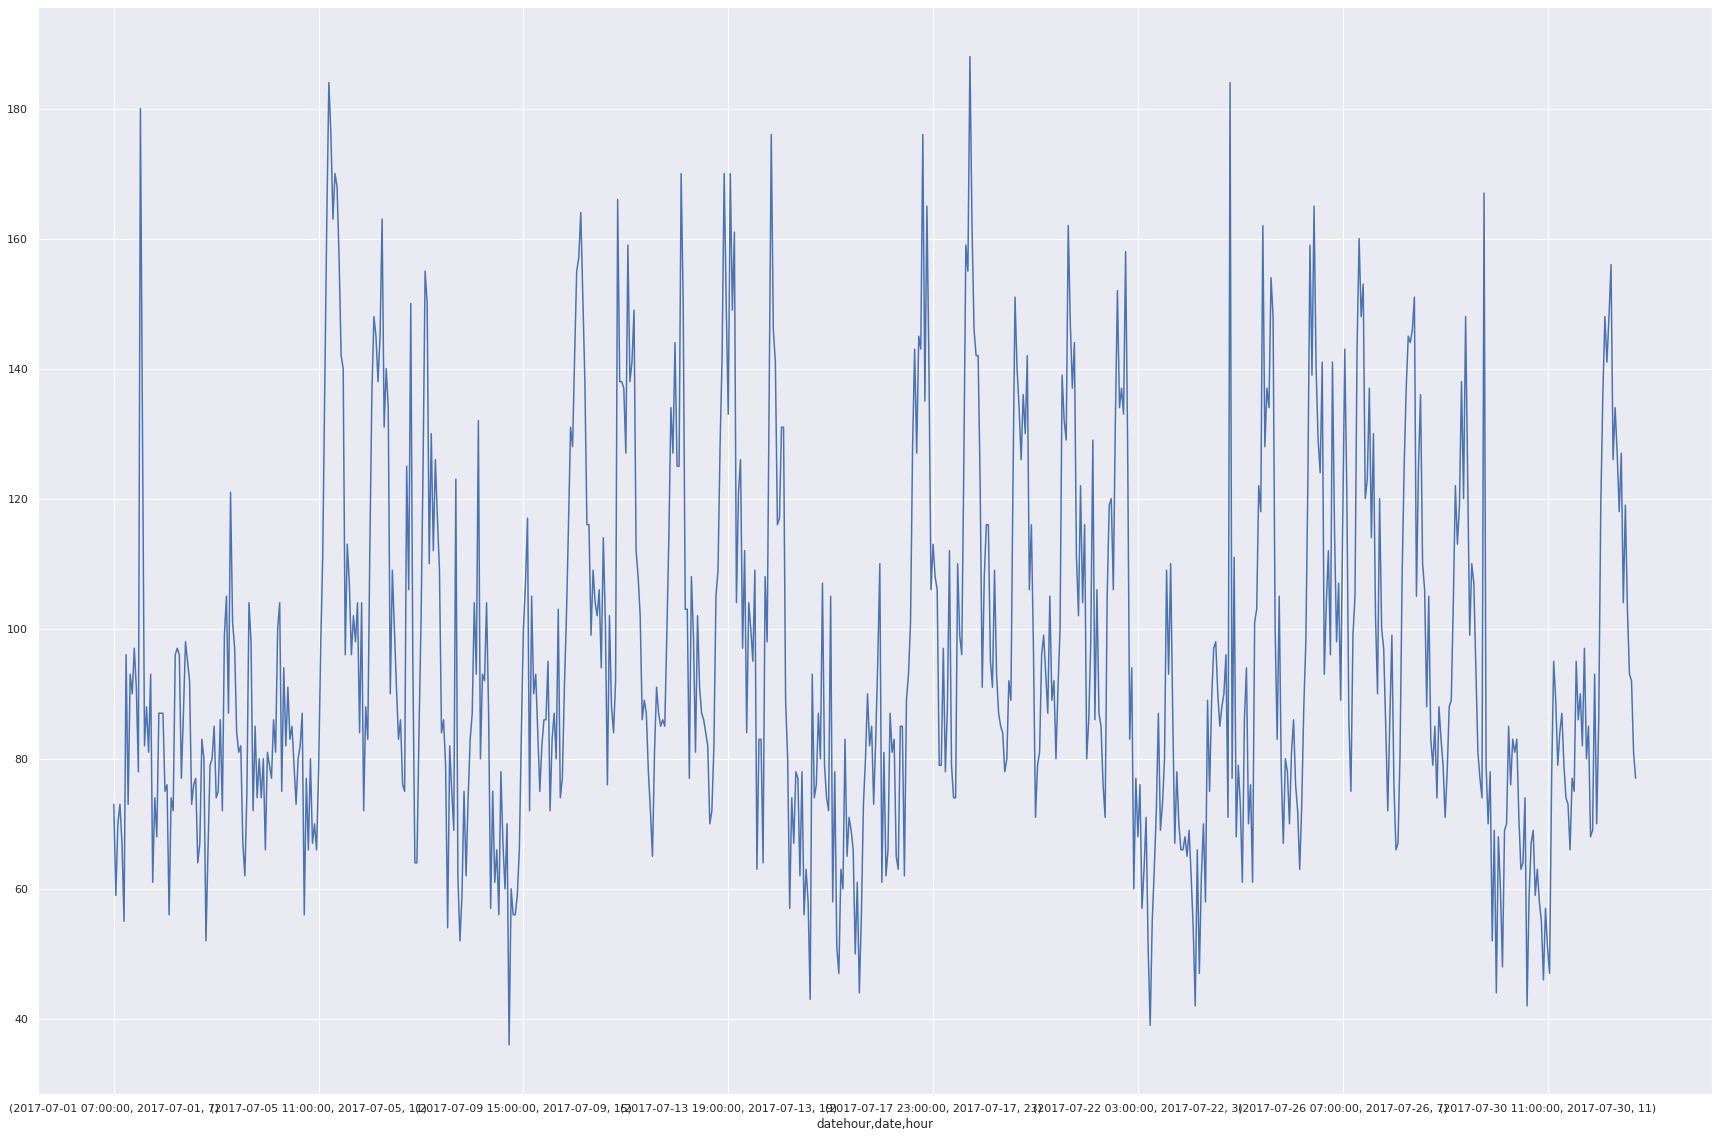

In [11]:
ts.plot(figsize=(30,20))
plt.show()

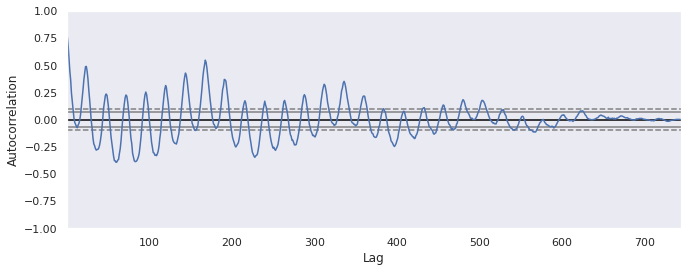

In [12]:
pd.plotting.autocorrelation_plot(ts)
plt.show()

In [13]:
ts_scaled = ts//20
ts_scaled.head()

datehour             date        hour
2017-07-01 07:00:00  2017-07-01  7       3
2017-07-01 08:00:00  2017-07-01  8       2
2017-07-01 09:00:00  2017-07-01  9       3
2017-07-01 10:00:00  2017-07-01  10      3
2017-07-01 11:00:00  2017-07-01  11      3
Name: visitStartTime, dtype: int64

In [14]:
ts_scaled.describe()

count    744.000000
mean       4.364247
std        1.507402
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        9.000000
Name: visitStartTime, dtype: float64

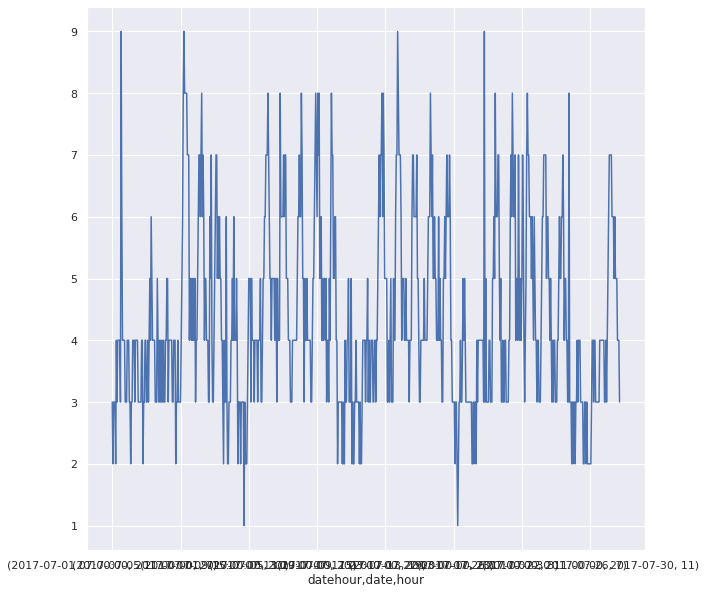

In [15]:
ts_scaled.plot(figsize=(10,10))
plt.show()

In [16]:
#ts_scaled.to_csv('load_full.csv', index=False)

## Prepare simulation results

### Generate trace

In [18]:
filenames = []

for i in range(1, 31):
    filenames.append('data/eventspart' + str(i) + '.txt')

trace = eventsToTrace(filenames)

#truncate parts before and after simulation
trace = trace[trace['time'] > datetime.datetime(2020, 9, 26, 14, 15)]
trace = trace[trace['time'] < datetime.datetime(2020, 9, 27, 3, 0)]

trace.head()

,time,name,podType,event
ba2ad388-374d-44f6-9a1b-961f0ea60200,2020-09-26 14:16:01,loadgenerator-79bff5bd57-lf2r8.16385b08d89b2303,loadgenerator,Created
f30e145a-c883-4c06-881b-f1d6674d6219,2020-09-26 14:16:01,loadgenerator-79bff5bd57-5vstf.16385b08d8a3dbed,loadgenerator,Created
308d1ed1-4ce1-4b1e-812f-5f57c0fa6006,2020-09-26 14:17:00,loadgenerator-79bff5bd57-5vstf.16385b16ae01aebb,loadgenerator,Killing
3f9eedcd-fc67-43c2-b0f2-ab09c2c63e3d,2020-09-26 14:17:17,frontend-5fcb8cdcdc-zbpr7.16385b1a8a38d1c1,frontend,Created
96746f22-a337-4986-a062-7ca3cfa45d42,2020-09-26 14:18:01,loadgenerator-79bff5bd57-2ld9p.16385b24df9cd32b,loadgenerator,Created


In [19]:
#filenames = []

#for i in range(1, 38):
#    filenames.append('data/real/realeventspart' + str(i) + '.txt')

#trace = eventsToTrace(filenames)

#truncate parts before and after simulation
#trace = trace[trace['time'] > datetime.datetime(2020, 9, 28, 1, 24)]

#trace.tail(14)

In [20]:
trace.shape

(677, 4)

### Generate Time Series

In [21]:
matrix = traceToTimeseries(trace)
matrix = matrix.set_index('time')
matrix['nrFrontends'] = matrix['nrFrontends'].astype(int)
matrix['nrLoadgenerators'] = matrix['nrLoadgenerators'].astype(int)
matrix.head()

,nrLoadgenerators,nrFrontends
time,,
2020-09-26 14:15:01,1,1
2020-09-26 14:16:01,1,1
2020-09-26 14:17:01,3,1
2020-09-26 14:18:01,2,1
2020-09-26 14:19:01,3,2


In [22]:
matrix.dtypes

nrLoadgenerators    int64
nrFrontends         int64
dtype: object

In [23]:
matrix.shape

(762, 2)

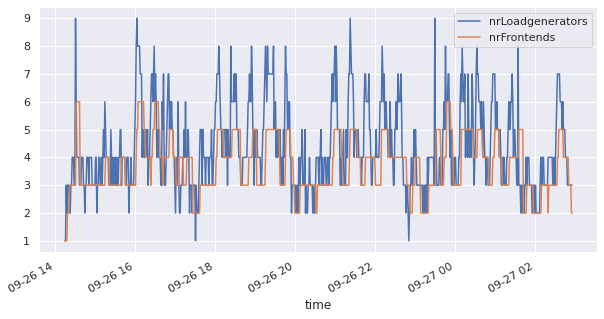

In [24]:
matrix.plot(y=['nrLoadgenerators', 'nrFrontends'], figsize=(10,5), grid=True)
plt.show()

In [25]:
matrix.describe()

,nrLoadgenerators,nrFrontends
count,762.000000,762.000000
mean,4.360892,3.692913
std,1.529283,1.017677
min,1.000000,1.000000
25%,3.000000,3.000000
50%,4.000000,4.000000
75%,5.000000,4.000000
max,9.000000,6.000000


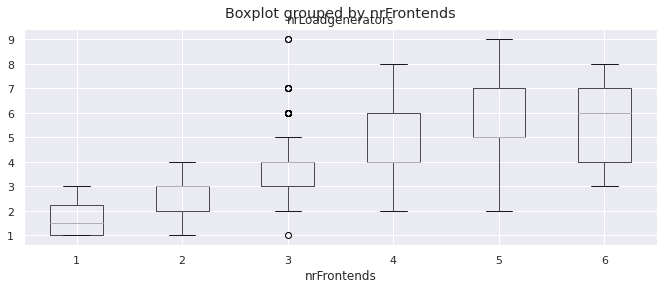

In [26]:
matrix.boxplot(column='nrLoadgenerators',by='nrFrontends')
plt.show()

In [27]:
# simple correlation
matrix["nrFrontends"].corr(matrix["nrLoadgenerators"], method='spearman')


0.5446986898674924

maximal correlation:  0.729049884471886
lag:  -3


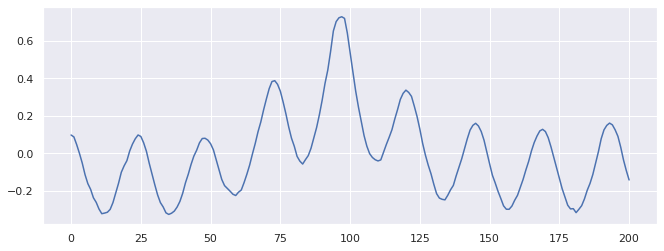

In [28]:
# ccf
def ccf(x, y, lag_max = 100):

    result = ss.correlate(y - np.mean(y), x - np.mean(x), method='direct') / (np.std(y) * np.std(x) * len(y))
    length = (len(result) - 1) // 2
    lo = length - lag_max
    hi = length + (lag_max + 1)

    return result[lo:hi]


c = ccf(matrix['nrFrontends'], matrix['nrLoadgenerators'])
print('maximal correlation: ', np.max(c))
print('lag: ', np.argmax(c) - 100)
plt.plot(c)
plt.show()

#### Feature engineering

TODO: describe

In [29]:
def computeFeatures(matrix):
    
    # add load and frontend numbers at times i-1,..., i-5
    lagged = []
    for i in range(1, 6):
        matrix_1 = matrix.shift(periods=i)
        matrix_1.columns = ['nrFrontends_' + str(i), 'nrLoadgenerators_' + str(i)]
        lagged.append(matrix_1)
    lagged.insert(0, matrix)
    features = pd.concat(lagged, axis=1)
    
    features.fillna(0, inplace=True)

    # add change in last step
    features['frontendChange'] = features['nrFrontends'] - features['nrFrontends_1']
    features['loadChange'] = features['nrLoadgenerators'] - features['nrLoadgenerators_1']
    
    #add time since last change in minutes
    features['decF'] = features['nrFrontends'] < features['nrFrontends_1']
    features['incF'] = features['nrFrontends'] > features['nrFrontends_1']
    features['decL'] = features['nrLoadgenerators'] < features['nrLoadgenerators_1']
    features['incL'] = features['nrLoadgenerators'] > features['nrLoadgenerators_1']

    features['lastIncF'] = datetime.timedelta(0)
    features['lastDecF'] = datetime.timedelta(0)
    features['lastIncL'] = datetime.timedelta(0)
    features['lastDecL'] = datetime.timedelta(0)

    lastIncF = features.index[0]
    lastDecF = features.index[0]
    lastIncL = features.index[0]
    lastDecL = features.index[0]
    for index, row in features.iterrows():
        if(row['incF']):
            lastIncF = index
        if(row['decF']):
            lastDecF = index
        if(row['incL']):
            lastIncL = index
        if(row['decL']):
            lastIncL = index
        features.at[index, 'lastIncF'] = index - lastIncF
        features.at[index, 'lastIncL'] = index - lastIncL
        features.at[index, 'lastDecF'] = index - lastDecF
        features.at[index, 'lastDecL'] = index - lastDecL
    
    # transform timedelta to number of minutes
    features['lastIncF'] = features['lastIncF'].apply(lambda x: x.total_seconds()//60)
    features['lastDecF'] = features['lastDecF'].apply(lambda x: x.total_seconds()//60)
    features['lastIncL'] = features['lastIncL'].apply(lambda x: x.total_seconds()//60)
    features['lastDecL'] = features['lastDecL'].apply(lambda x: x.total_seconds()//60)
    
    return features

In [30]:
features = computeFeatures(matrix)
features.head()

,nrLoadgenerators,nrFrontends,nrFrontends_1,nrLoadgenerators_1,nrFrontends_2,nrLoadgenerators_2,nrFrontends_3,nrLoadgenerators_3,nrFrontends_4,nrLoadgenerators_4,...,frontendChange,loadChange,decF,incF,decL,incL,lastIncF,lastDecF,lastIncL,lastDecL
time,,,,,,,,,,,,,,,,,,,,,
2020-09-26 14:15:01,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,False,True,False,True,0.0,0.0,0.0,0.0
2020-09-26 14:16:01,1,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,False,False,False,False,1.0,1.0,1.0,1.0
2020-09-26 14:17:01,3,1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,2.0,False,False,False,True,2.0,2.0,0.0,2.0
2020-09-26 14:18:01,2,1,3.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,-2.0,1.0,True,False,False,True,3.0,0.0,0.0,3.0
2020-09-26 14:19:01,3,2,2.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,...,0.0,2.0,False,False,False,True,4.0,1.0,0.0,4.0


In [31]:
features.dtypes

nrLoadgenerators        int64
nrFrontends             int64
nrFrontends_1         float64
nrLoadgenerators_1    float64
nrFrontends_2         float64
nrLoadgenerators_2    float64
nrFrontends_3         float64
nrLoadgenerators_3    float64
nrFrontends_4         float64
nrLoadgenerators_4    float64
nrFrontends_5         float64
nrLoadgenerators_5    float64
frontendChange        float64
loadChange            float64
decF                     bool
incF                     bool
decL                     bool
incL                     bool
lastIncF              float64
lastDecF              float64
lastIncL              float64
lastDecL              float64
dtype: object

In [32]:
features.corr(method='spearman')

,nrLoadgenerators,nrFrontends,nrFrontends_1,nrLoadgenerators_1,nrFrontends_2,nrLoadgenerators_2,nrFrontends_3,nrLoadgenerators_3,nrFrontends_4,nrLoadgenerators_4,...,frontendChange,loadChange,decF,incF,decL,incL,lastIncF,lastDecF,lastIncL,lastDecL
nrLoadgenerators,1.000000,0.544699,0.735142,0.454511,0.655729,0.363991,0.566357,0.288257,0.471862,0.224825,...,-0.487514,0.719170,0.381383,-0.210162,-0.385182,0.615147,0.335649,-0.390261,-0.345716,0.017049
nrFrontends,0.544699,1.000000,0.644704,0.908529,0.719718,0.811107,0.733970,0.706011,0.738375,0.599399,...,0.000910,-0.084806,-0.045228,0.223359,0.254632,-0.089477,0.071287,0.049466,-0.121688,0.026641
nrFrontends_1,0.735142,0.644704,1.000000,0.545674,0.735933,0.455567,0.656747,0.365987,0.567581,0.290439,...,-0.726337,0.380425,0.607991,-0.358484,-0.162112,0.295590,0.433162,-0.596595,-0.207271,0.023556
nrLoadgenerators_1,0.454511,0.908529,0.545674,1.000000,0.645553,0.908593,0.720473,0.812048,0.734716,0.707174,...,0.066893,-0.241546,-0.088534,0.233347,0.364471,-0.206451,0.000179,0.116822,-0.085939,0.034587
nrFrontends_2,0.655729,0.719718,0.735933,0.645553,1.000000,0.546645,0.736721,0.457294,0.657761,0.367975,...,-0.337812,0.227121,0.243088,-0.120897,-0.055814,0.160970,0.370674,-0.332289,-0.141747,0.030045
nrLoadgenerators_2,0.363991,0.811107,0.455567,0.908593,0.546645,1.000000,0.646399,0.909322,0.721224,0.812984,...,0.105126,-0.281174,-0.112182,0.220272,0.359132,-0.243393,-0.057419,0.154559,-0.045697,0.042513
nrFrontends_3,0.566357,0.733970,0.656747,0.720473,0.736721,0.646399,1.000000,0.548148,0.737506,0.459015,...,-0.215738,0.074545,0.127990,-0.047933,0.014426,0.028269,0.321956,-0.183938,-0.053728,0.036515
nrLoadgenerators_3,0.288257,0.706011,0.365987,0.812048,0.457294,0.909322,0.548148,1.000000,0.647620,0.909653,...,0.141287,-0.303480,-0.142498,0.202305,0.342694,-0.256620,-0.108519,0.192663,-0.019959,0.048298
nrFrontends_4,0.471862,0.738375,0.567581,0.734716,0.657761,0.721224,0.737506,0.647620,1.000000,0.549644,...,-0.097348,-0.038944,0.033922,0.010787,0.104734,-0.045127,0.264687,-0.064347,-0.045153,0.042966
nrLoadgenerators_4,0.224825,0.599399,0.290439,0.707174,0.367975,0.812984,0.459015,0.909653,0.549644,1.000000,...,0.160753,-0.305038,-0.150060,0.179754,0.330327,-0.245497,-0.151200,0.199770,-0.022425,0.054064


## Models

### 1. Random forest
* columns not lin indep (-> no GLM)
* frontends depend on load 
* load could be modelled using time series model 

#### a) Regression


In [33]:
labels = np.array(features['nrFrontends'])
features_ml = features.drop('nrFrontends', axis = 1)

feature_list = list(features_ml.columns)
features_ml = np.array(features_ml)

In [34]:
#random split 80 20
train_features, test_features, train_labels, test_labels = train_test_split(features_ml, labels, test_size = 0.2, random_state = 42)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (609, 21)
Training Labels Shape: (609,)
Testing Features Shape: (153, 21)
Testing Labels Shape: (153,)


In [35]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)# Train the model on training data
rf.fit(train_features, train_labels);

In [36]:
predictions = rf.predict(test_features)

errors = abs(predictions - test_labels)
print('Mean Absolute Error:', round(np.mean(errors), 2), '....')

Mean Absolute Error: 0.14 ....


In [37]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 95.8 %.


In [38]:
pred_rounded = np.rint(predictions).astype(int)
# Making the Confusion Matrix
print(pd.crosstab(test_labels, pred_rounded, rownames=['Actual Frontends'], colnames=['Predicted Frontends'], normalize='index'))


Predicted Frontends    1         2         3         4         5         6
Actual Frontends                                                          
1                    1.0  0.000000  0.000000  0.000000  0.000000  0.000000
2                    0.0  0.888889  0.111111  0.000000  0.000000  0.000000
3                    0.0  0.029851  0.895522  0.059701  0.000000  0.014925
4                    0.0  0.000000  0.028571  0.914286  0.057143  0.000000
5                    0.0  0.000000  0.000000  0.081081  0.891892  0.027027
6                    0.0  0.000000  0.000000  0.000000  0.000000  1.000000


In [54]:
balanced_accuracy_score(test_labels, pred_rounded)

0.931764813854366

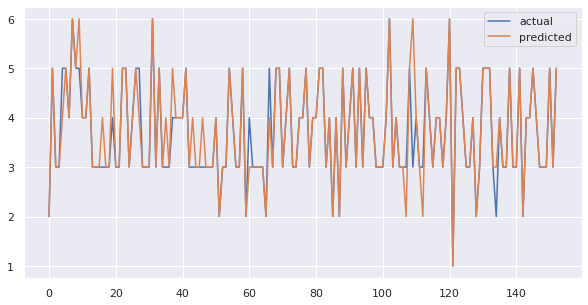

In [40]:
results = pd.DataFrame({'actual': test_labels, 'predicted': pred_rounded})
results.plot(y=['actual', 'predicted'], figsize=(10,5), grid=True)
plt.show()

In [41]:
#features['pred'] = rf.predict(features_ml)
#features.plot(y=['pred', 'nrFrontends'], figsize=(10,5), grid=True)
#plt.show()

In [42]:
l = list(zip(features.drop('nrFrontends', axis = 1).columns, rf.feature_importances_))

sorted(l, key = lambda x: x[1], reverse=True) 


[('nrLoadgenerators_1', 0.825748289701068),
 ('nrFrontends_2', 0.03608987825765513),
 ('nrFrontends_1', 0.03170361156853913),
 ('lastDecL', 0.02885706551979679),
 ('nrFrontends_4', 0.017842855489245267),
 ('frontendChange', 0.012177388878567725),
 ('lastDecF', 0.007975492700796586),
 ('nrFrontends_5', 0.007919190632008702),
 ('lastIncF', 0.007516400414823015),
 ('nrFrontends_3', 0.005003917557052988),
 ('nrLoadgenerators', 0.003244548443825903),
 ('loadChange', 0.0028923377558762405),
 ('nrLoadgenerators_5', 0.0028414621351385877),
 ('lastIncL', 0.002315621105122574),
 ('nrLoadgenerators_4', 0.0018679088328192597),
 ('decF', 0.001788049345053187),
 ('incF', 0.0012171386268928293),
 ('decL', 0.001128125113541678),
 ('nrLoadgenerators_3', 0.0008700966389529993),
 ('nrLoadgenerators_2', 0.0006250375692290342),
 ('incL', 0.00037558371399421436)]

In [43]:
# Train and evaluate with reduced number of features
features_filtered = features[['nrLoadgenerators_1', 'nrFrontends_2', 'nrFrontends_1', 'lastDecL', 'nrFrontends_4', 'frontendChange']]

feature_list_red = list(features_filtered.columns)
features_filtered = np.array(features_filtered)

#random split 80 20
train_features_red, test_features_red, train_labels_red, test_labels_red = train_test_split(features_filtered, labels, test_size = 0.2, random_state = 42)

rf_red = RandomForestRegressor(n_estimators = 1000, random_state = 42)# Train the model on training data
rf_red.fit(train_features_red, train_labels_red);

In [55]:
predictions_red = rf_red.predict(test_features_red)

pred_rounded_red = np.rint(predictions_red).astype(int)
# Making the Confusion Matrix
print(pd.crosstab(test_labels, pred_rounded_red, rownames=['Actual Frontends'], colnames=['Predicted Frontends'], normalize='index'))

balanced_accuracy_score(test_labels, pred_rounded_red)



Predicted Frontends    1         2         3         4         5         6
Actual Frontends                                                          
1                    1.0  0.000000  0.000000  0.000000  0.000000  0.000000
2                    0.0  1.000000  0.000000  0.000000  0.000000  0.000000
3                    0.0  0.014925  0.925373  0.044776  0.000000  0.014925
4                    0.0  0.000000  0.000000  0.942857  0.057143  0.000000
5                    0.0  0.000000  0.000000  0.054054  0.945946  0.000000
6                    0.0  0.000000  0.000000  0.000000  0.000000  1.000000


0.9690293705219077

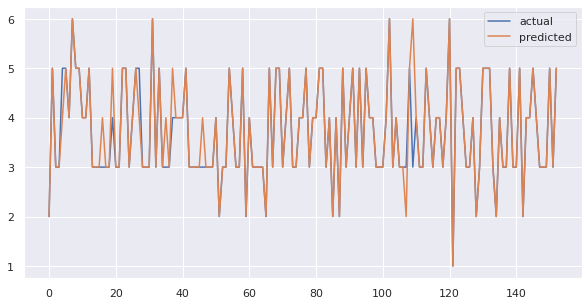

In [45]:
results = pd.DataFrame({'actual': test_labels, 'predicted': pred_rounded_red})
results.plot(y=['actual', 'predicted'], figsize=(10,5), grid=True)
plt.show()

#### b) Multiclass classification

In [46]:
factor = pd.factorize(features['nrFrontends'])
labels_cat = factor[0]
definitions = factor[1]

# train test split
X_train, X_test, y_train, y_test = train_test_split(features_ml, labels_cat, test_size = 0.2, random_state = 42)

print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

classifier = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

Training Features Shape: (609, 21)
Training Labels Shape: (609,)
Testing Features Shape: (153, 21)
Testing Labels Shape: (153,)


RandomForestClassifier(criterion='entropy', n_estimators=1000, random_state=42)

In [47]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
#Reverse factorizetpandas 
reversefactor = dict(zip(range(6),definitions))
y_test = np.vectorize(reversefactor.get)(y_test)
y_pred = np.vectorize(reversefactor.get)(y_pred)
# Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual Frontends'], colnames=['Predicted Frontends'], normalize='index'))


Predicted Frontends    1         2         3         4         5         6
Actual Frontends                                                          
1                    1.0  0.000000  0.000000  0.000000  0.000000  0.000000
2                    0.0  0.888889  0.111111  0.000000  0.000000  0.000000
3                    0.0  0.014925  0.940299  0.029851  0.000000  0.014925
4                    0.0  0.000000  0.085714  0.857143  0.057143  0.000000
5                    0.0  0.000000  0.000000  0.135135  0.864865  0.000000
6                    0.0  0.000000  0.000000  0.000000  0.250000  0.750000


In [56]:
balanced_accuracy_score(y_test, y_pred)

0.8835325197265496

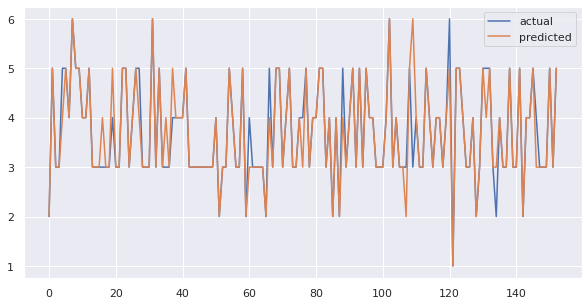

In [49]:
results = pd.DataFrame({'actual': y_test, 'predicted': y_pred})
results.plot(y=['actual', 'predicted'], figsize=(10,5), grid=True)
plt.show()

### Cross validation - split on weeks

In [48]:
features.index.apply(lambda x: x.isocalendar()[1])




AttributeError: 'DatetimeIndex' object has no attribute 'apply'

In [ ]:
labels = np.array(features['nrFrontends'])
features_ml = features.drop('nrFrontends', axis = 1)

feature_list = list(features_ml.columns)
features_ml = np.array(features_ml)

# Test on Random data

In [57]:
#generate trace
filenames = []

for i in range(1, 8):
    filenames.append('data/randomeventspart' + str(i) + '.txt')

trace_random = eventsToTrace(filenames)

#truncate parts before and after simulation
trace_random = trace_random[trace_random['time'] > datetime.datetime(2020, 9, 27, 22, 15)]
trace_random = trace_random[trace_random['time'] < datetime.datetime(2020, 9, 28, 0, 22)]

trace_random.head()

,time,name,podType,event
ac45aca2-97ff-4881-8cd3-224c2cd5944e,2020-09-27 22:19:35,loadgenerator-79bff5bd57-kcdpw.1638c400d04d1796,loadgenerator,Created
cf14c673-c17d-4818-84f8-a1627a6064ee,2020-09-27 22:19:35,loadgenerator-79bff5bd57-7l98l.1638c400cd19943d,loadgenerator,Created
a4e7b6e1-9058-4a11-8e18-19d85be78faa,2020-09-27 22:21:12,frontend-5fcb8cdcdc-97t4z.1638c41774d4eb7a,frontend,Created
99eda45e-c7e9-42e5-8a22-f8a542d16508,2020-09-27 22:21:12,frontend-5fcb8cdcdc-xzp2w.1638c41774c2fd92,frontend,Created
016ba9e1-0f96-4aa0-a69b-3c3e304e9554,2020-09-27 22:23:35,loadgenerator-79bff5bd57-dbl52.1638c438c6681e03,loadgenerator,Created


In [58]:
matrix_rand = traceToTimeseries(trace_random)
matrix_rand = matrix_rand.set_index('time')
matrix_rand['nrFrontends'] = matrix_rand['nrFrontends'].astype(int)
matrix_rand['nrLoadgenerators'] = matrix_rand['nrLoadgenerators'].astype(int)
matrix_rand.head()

,nrLoadgenerators,nrFrontends
time,,
2020-09-27 22:18:35,1,1
2020-09-27 22:19:35,1,1
2020-09-27 22:20:35,3,1
2020-09-27 22:21:35,3,1
2020-09-27 22:22:35,3,3


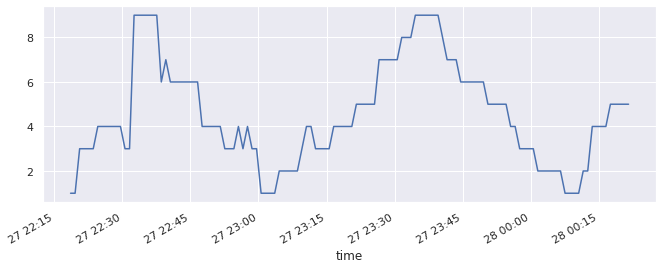

In [59]:
matrix_rand['nrLoadgenerators'].plot()
plt.show()

In [60]:
matrix_rand.groupby('nrLoadgenerators').count()

,nrFrontends
nrLoadgenerators,
1,10
2,13
3,21
4,26
5,15
6,14
7,9
8,4
9,12


In [61]:
features_rand = computeFeatures(matrix_rand)
labels_rand = np.array(features_rand['nrFrontends'])
features_ml_rand = features_rand.drop('nrFrontends', axis = 1)

features_ml_rand = np.array(features_ml_rand)


In [62]:
predictions_rand = rf.predict(features_ml_rand)

errors = abs(predictions_rand - labels_rand)
print('Mean Absolute Error:', round(np.mean(errors), 2), '....')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / labels_rand)# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 0.28 ....
Accuracy: 93.05 %.


In [63]:
pred_rounded_rand = np.rint(predictions_rand).astype(int)
# Making the Confusion Matrix
print(pd.crosstab(labels_rand, pred_rounded_rand, rownames=['Actual Frontends'], colnames=['Predicted Frontends'], normalize='index'))


Predicted Frontends    1         2         3         4         5         6
Actual Frontends                                                          
1                    1.0  0.000000  0.000000  0.000000  0.000000  0.000000
2                    0.0  0.888889  0.111111  0.000000  0.000000  0.000000
3                    0.0  0.043478  0.913043  0.021739  0.021739  0.000000
4                    0.0  0.000000  0.117647  0.823529  0.000000  0.058824
5                    0.0  0.000000  0.000000  0.000000  0.368421  0.631579
6                    0.0  0.000000  0.000000  0.000000  0.090909  0.909091
7                    0.0  0.000000  0.000000  0.000000  0.000000  1.000000


In [64]:
balanced_accuracy_score(labels_rand, pred_rounded_rand)

0.7004248200909932

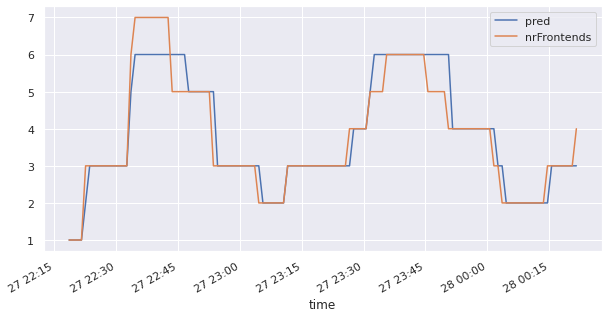

In [65]:
features_rand['pred'] = pred_rounded_rand
features_rand.plot(y=['pred', 'nrFrontends'], figsize=(10,5), grid=True)
plt.show()

In [66]:

mse = mean_squared_error(features_rand['nrFrontends'], features_rand['pred'])


rmse = math.sqrt(mse)


print(rmse)

0.5462482007056806


#### reduced features

In [67]:
features_rand_red = features_rand[['nrLoadgenerators_1', 'nrFrontends_2', 'nrFrontends_1', 'lastDecL', 'nrFrontends_4', 'frontendChange']]

features_rand_red = np.array(features_rand_red)

predictions_rand_red = rf_red.predict(features_rand_red)

pred_rounded_rand_red = np.rint(predictions_rand_red).astype(int)
# Making the Confusion Matrix
print(pd.crosstab(labels_rand, pred_rounded_rand_red, rownames=['Actual Frontends'], colnames=['Predicted Frontends'], normalize='index'))

balanced_accuracy_score(labels_rand, pred_rounded_rand_red)

Predicted Frontends    1         2         3         4         5         6
Actual Frontends                                                          
1                    1.0  0.000000  0.000000  0.000000  0.000000  0.000000
2                    0.0  0.944444  0.055556  0.000000  0.000000  0.000000
3                    0.0  0.021739  0.913043  0.043478  0.021739  0.000000
4                    0.0  0.000000  0.000000  0.823529  0.176471  0.000000
5                    0.0  0.000000  0.000000  0.000000  0.736842  0.263158
6                    0.0  0.000000  0.000000  0.000000  0.090909  0.909091
7                    0.0  0.000000  0.000000  0.000000  0.000000  1.000000


0.7609929069748694

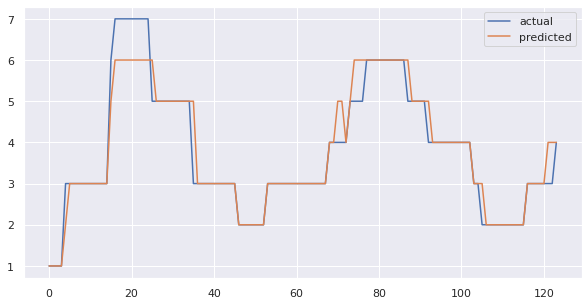

In [68]:
results = pd.DataFrame({'actual': labels_rand, 'predicted': pred_rounded_rand_red})
results.plot(y=['actual', 'predicted'], figsize=(10,5), grid=True)
plt.show()

In [69]:
# Test Regression
factor_rand = pd.factorize(features_rand['nrFrontends'])
labels_cat_rand = factor_rand[0]
definitions_rand = factor_rand[1]




In [70]:
# Predicting the Test set results
y_pred_rand = classifier.predict(features_ml_rand)
reversefactor = dict(zip(range(7),definitions_rand))
y_rand = np.vectorize(reversefactor.get)(labels_cat_rand)
y_pred_rand = np.vectorize(reversefactor.get)(y_pred_rand)

# Making the Confusion Matrix
print(pd.crosstab(y_rand, y_pred_rand, rownames=['Actual Frontends'], colnames=['Predicted Frontends'], normalize='index'))

Predicted Frontends    1         2         3         5         6         7
Actual Frontends                                                          
1                    1.0  0.000000  0.000000  0.000000  0.000000  0.000000
2                    0.0  0.000000  0.888889  0.000000  0.111111  0.000000
3                    0.0  0.000000  0.043478  0.021739  0.934783  0.000000
4                    0.0  0.117647  0.000000  0.764706  0.117647  0.000000
5                    0.0  0.684211  0.000000  0.052632  0.000000  0.263158
6                    0.0  0.000000  0.000000  0.000000  0.000000  1.000000
7                    0.0  0.000000  0.000000  0.000000  0.000000  1.000000


In [71]:
balanced_accuracy_score(y_rand, y_pred_rand)

0.2994442628309905

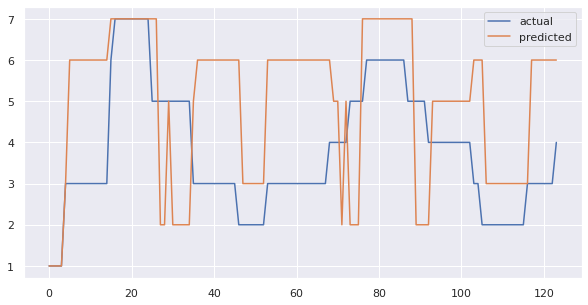

In [72]:
results = pd.DataFrame({'actual': y_rand, 'predicted': y_pred_rand})
results.plot(y=['actual', 'predicted'], figsize=(10,5), grid=True)
plt.show()

# Minute data

**TODO**
1 leave 1 out CV (je 1 Woche raus)
2 random confusion matrix neu berechnen
3 feature grtance - sort by importance + alles weglassen was in 2. nk stelle 0 hat
4 beschreibungen und interpretation schreiben
5 verteilung der random daten
6 bestehendes Model verbessern: filter drüber legen, hidden markov, vl doch noch was zeitreihenspezifisches
7 neue daten für min=min aufbereiten und damit neuen classifier trainieren
8 proof of concept: limitations - more nodes + power for more load needed - RF is sensible to unbalanced groups



* for interpretation: not dependentant on current load but on recent load --> kubernetes takes some time to react - or it takes time for users to become active?
* write
* mention 1h = 1 min

RF:
Zeitlivhe abhängigkeit egal -> robust gegen changes of season & trend
Lineare abhängigkeit der inputvektoren egal
Verwendung von kovariablen möglich
Via load forecasting predicted load mögliches inputfeature, dann n-step ahead prediction möglich



In [ ]:
filenames = []

for i in range(1, 38):
    filenames.append('data/real/realeventspart' + str(i) + '.txt')

trace = eventsToTrace(filenames)

#truncate parts before and after simulation
#trace = trace[trace['time'] > datetime.datetime(2020, 9, 26, 14, 15)]
#trace = trace[trace['time'] < datetime.datetime(2020, 9, 27, 3, 0)]

trace.head()